In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from zkyhaxpy import io_tools, gis_tools
import rasterio
import os
import shutil
import numpy as np
from tqdm.notebook import tqdm

In [2]:
df_extracted_aod055 = pd.read_csv(r'../data/df_extracted_aod055.csv')
del(df_extracted_aod055['row'])
del(df_extracted_aod055['col'])
del(df_extracted_aod055['tile_id'])

df_extracted_dem = pd.read_csv(r'../data/df_extracted_dem.csv')
del(df_extracted_dem['row'])
del(df_extracted_dem['col'])


gdf_openaq = gpd.read_file('../data/gdf_openaq.gpkg')
print('gdf_openaq has been loaded.')
if gdf_openaq.index.name is None:
    gdf_openaq = gdf_openaq.set_index('measurement_id')

gdf_openaq has been loaded.


In [3]:
gdf_openaq = gdf_openaq[gdf_openaq['value'] != -999].copy()


gdf_openaq

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,lat,long,datetime,year,month,geometry
measurement_id,,,,,,,,,,,,,,,,,
0,8893,Vientiane,pm25,10.000000,µg/m³,TH,None,False,None,Governmental Organization,reference grade,17.896122,102.640000,2019-06-30 00:00:00+00:00,2019,6,POINT (102.64000 17.89612)
1,8893,Vientiane,pm25,18.000000,µg/m³,TH,None,False,None,Governmental Organization,reference grade,17.896122,102.640000,2019-06-29 23:00:00+00:00,2019,6,POINT (102.64000 17.89612)
2,8893,Vientiane,pm25,17.000000,µg/m³,TH,None,False,None,Governmental Organization,reference grade,17.896122,102.640000,2019-06-29 22:00:00+00:00,2019,6,POINT (102.64000 17.89612)
3,8893,Vientiane,pm25,12.000000,µg/m³,TH,None,False,None,Governmental Organization,reference grade,17.896122,102.640000,2019-06-29 21:00:00+00:00,2019,6,POINT (102.64000 17.89612)
4,8893,Vientiane,pm25,15.000000,µg/m³,TH,None,False,None,Governmental Organization,reference grade,17.896122,102.640000,2019-06-29 20:00:00+00:00,2019,6,POINT (102.64000 17.89612)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218204,2694254,Soi Kheha Pattana 1,pm25,39.079167,µg/m³,TH,None,False,None,Private Organization,low-cost sensor,13.709941,100.576022,2024-04-02 04:00:00+00:00,2024,4,POINT (100.57602 13.70994)
218205,2694254,Soi Kheha Pattana 1,pm25,39.387797,µg/m³,TH,None,False,None,Private Organization,low-cost sensor,13.709941,100.576022,2024-04-02 03:00:00+00:00,2024,4,POINT (100.57602 13.70994)
218206,2694254,Soi Kheha Pattana 1,pm25,37.445286,µg/m³,TH,None,False,None,Private Organization,low-cost sensor,13.709941,100.576022,2024-04-02 02:00:00+00:00,2024,4,POINT (100.57602 13.70994)


In [4]:
df_extracted_aod055 = df_extracted_aod055[df_extracted_aod055['aod_055'] >= 0].copy()
df_extracted_aod055 = df_extracted_aod055.set_index('measurement_id')
df_extracted_aod055

,aod_055,aod_datetime
measurement_id,,
4127,185.0,2019-12-11 03:40:00+00:00
4128,185.0,2019-12-11 03:40:00+00:00
12436,63.0,2021-01-10 07:10:00+00:00
12437,63.0,2021-01-10 07:10:00+00:00
66393,241.0,2021-06-14 03:50:00+00:00
...,...,...
39388,266.0,2021-05-20 03:50:00+00:00
45181,368.0,2021-05-20 03:50:00+00:00
45182,368.0,2021-05-20 03:50:00+00:00


In [5]:
df_extracted_dem = df_extracted_dem.copy()
df_extracted_dem = df_extracted_dem.set_index('measurement_id')
df_extracted_dem

,dem
measurement_id,
0,174.0
1,174.0
2,174.0
3,174.0
4,174.0
...,...
205085,23.0
205086,23.0
205087,23.0


In [6]:
df_joined = gdf_openaq.merge(df_extracted_aod055, how='inner', left_index=True, right_index=True).copy()
df_joined = df_joined.merge(df_extracted_dem, how='inner', left_index=True, right_index=True).copy()
df_joined = df_joined.rename(columns={'value':'pm25'})
df_joined

,locationId,location,parameter,pm25,unit,country,city,isMobile,isAnalysis,entity,sensorType,lat,long,datetime,year,month,geometry,aod_055,aod_datetime,dem
measurement_id,,,,,,,,,,,,,,,,,,,,
184,8893,Vientiane,pm25,5.000000,µg/m³,TH,None,False,None,Governmental Organization,reference grade,17.896122,102.640000,2019-06-22 04:00:00+00:00,2019,6,POINT (102.64000 17.89612),149.0,2019-06-22 03:15:00+00:00,174.0
185,8893,Vientiane,pm25,8.000000,µg/m³,TH,None,False,None,Governmental Organization,reference grade,17.896122,102.640000,2019-06-22 03:00:00+00:00,2019,6,POINT (102.64000 17.89612),149.0,2019-06-22 03:15:00+00:00,174.0
204,8893,Vientiane,pm25,4.000000,µg/m³,TH,None,False,None,Governmental Organization,reference grade,17.896122,102.640000,2019-06-21 08:00:00+00:00,2019,6,POINT (102.64000 17.89612),187.0,2019-06-21 07:15:00+00:00,174.0
205,8893,Vientiane,pm25,2.000000,µg/m³,TH,None,False,None,Governmental Organization,reference grade,17.896122,102.640000,2019-06-21 07:00:00+00:00,2019,6,POINT (102.64000 17.89612),187.0,2019-06-21 07:15:00+00:00,174.0
207,8893,Vientiane,pm25,4.000000,µg/m³,TH,None,False,None,Governmental Organization,reference grade,17.896122,102.640000,2019-06-21 05:00:00+00:00,2019,6,POINT (102.64000 17.89612),43.0,2019-06-21 04:15:00+00:00,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218166,2692645,Vibhavadi Rangsit 11 Alley Lane 10,pm25,41.082341,µg/m³,TH,None,False,None,Private Organization,low-cost sensor,13.824551,100.550283,2024-04-02 08:00:00+00:00,2024,4,POINT (100.55028 13.82455),206.0,2024-04-02 07:40:00+00:00,7.0
218167,2692645,Vibhavadi Rangsit 11 Alley Lane 10,pm25,43.248809,µg/m³,TH,None,False,None,Private Organization,low-cost sensor,13.824551,100.550283,2024-04-02 07:00:00+00:00,2024,4,POINT (100.55028 13.82455),206.0,2024-04-02 07:40:00+00:00,7.0
218170,2692645,Vibhavadi Rangsit 11 Alley Lane 10,pm25,43.476191,µg/m³,TH,None,False,None,Private Organization,low-cost sensor,13.824551,100.550283,2024-04-02 04:00:00+00:00,2024,4,POINT (100.55028 13.82455),470.0,2024-04-02 03:45:00+00:00,7.0


<Axes: xlabel='dem', ylabel='pm25'>

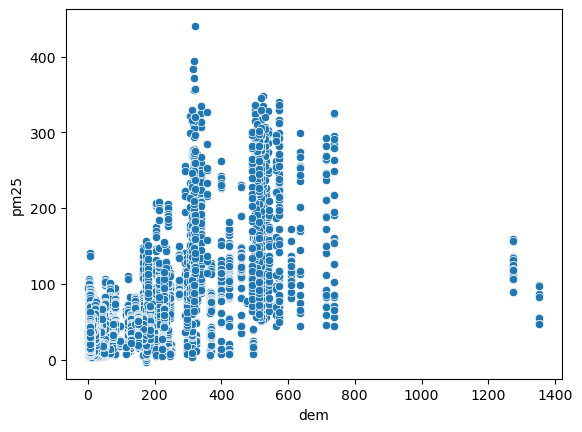

In [7]:
sns.scatterplot(data=df_joined, x='dem', y='pm25')

<Axes: xlabel='aod_055', ylabel='pm25'>

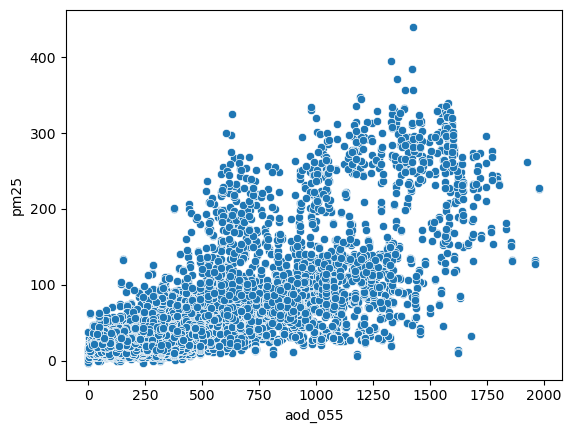

In [8]:
sns.scatterplot(data=df_joined, x='aod_055', y='pm25')

In [9]:
df_pm25 = df_joined.reindex(columns=['pm25', 'aod_055', 'dem']).copy()
df_pm25

,pm25,aod_055,dem
measurement_id,,,
184,5.000000,149.0,174.0
185,8.000000,149.0,174.0
204,4.000000,187.0,174.0
205,2.000000,187.0,174.0
207,4.000000,43.0,174.0
...,...,...,...
218166,41.082341,206.0,7.0
218167,43.248809,206.0,7.0
218170,43.476191,470.0,7.0


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Load your sample DataFrame (replace with your actual data)
# Assuming your DataFrame is named 'df' and contains columns 'pm25', 'aod_055', and 'dem'
# You can replace the sample data with your actual data


# Define features (X) and target (y)
X = df_pm25[['aod_055', 'dem']]
y = df_pm25['pm25']

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()

# Define hyperparameters for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, verbose=2, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_rf_model.predict(X_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [11]:

rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print messages
print("Random Forest model training completed.")
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best RMSE on test set: {rmse:.2f}")


Random Forest model training completed.
Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE on test set: 19.85


# OLS

In [12]:
import statsmodels.api as sm

# Fit OLS model
X_train_ols = sm.add_constant(X_train)  # Add constant term
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Get summary of OLS model
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     7101.
Date:                Tue, 16 Apr 2024   Prob (F-statistic):               0.00
Time:                        07:24:29   Log-Likelihood:                -37183.
No. Observations:                7427   AIC:                         7.437e+04
Df Residuals:                    7424   BIC:                         7.439e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4635      0.664     -5.219      0.0

In [13]:
import xgboost as xgb

# Initialize XGB model
xgb_model = xgb.XGBRegressor()

# Define hyperparameters (you can adjust these)
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01]
}

# Initialize grid search for XGB
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_params, cv=kf, verbose=2, n_jobs=-1)

# Fit grid search to training data
xgb_grid_search.fit(X_train, y_train)

# Get best XGB model
best_xgb_model = xgb_grid_search.best_estimator_

# Evaluate on test set
y_pred_xgb = best_xgb_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)

# Print messages
print("Random Forest model training completed.")
print(f"Best RMSE on test set: {rmse:.2f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Random Forest model training completed.
Best RMSE on test set: 23.82


## Predict grid in Chiangmai 

In [35]:
df_chiangmai_grid = pd.read_parquet(r'../data/df_chiangmai_grid.parquet')
df_chiangmai_dem = pd.read_parquet(r'..\data\df_chiangmai_dem.parquet')
df_chiangmai_joined = df_chiangmai_grid.merge(df_chiangmai_dem, how='inner', left_index=True, right_index=True)
df_chiangmai_joined



In [42]:
df_chiangmai_joined['x'] = df_chiangmai_joined['lat']*111
df_chiangmai_joined['x'] = df_chiangmai_joined['x'] - df_chiangmai_joined['x'].min()
df_chiangmai_joined['y'] = df_chiangmai_joined['lon']*111
df_chiangmai_joined['y'] = df_chiangmai_joined['y'] - df_chiangmai_joined['y'].min()
df_chiangmai_joined['z'] = df_chiangmai_joined['dem']/1000
df_chiangmai_joined['z'] = df_chiangmai_joined['z'] - df_chiangmai_joined['z'].min()


lon,98.0846,98.0936,98.1026,98.1115,98.1205,98.1295,98.1385,98.1475,98.1564,98.1654,...,99.5039,99.5129,99.5219,99.5309,99.5398,99.5488,99.5578,99.5668,99.5758,99.5848
lat,,,,,,,,,,,,,,,,,,,,,
17.2576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17.2666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17.2756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17.2846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17.2936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20.1143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,992.0,828.0,763.0,722.0,785.0,754.0,NaN,NaN,NaN,NaN
20.1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1074.0,899.0,822.0,856.0,913.0,1006.0,908.0,NaN,NaN,NaN
20.1322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1240.0,1058.0,949.0,1049.0,1072.0,1121.0,NaN,NaN,NaN,NaN


In [70]:
a = [[1, 2], [3, 4]]


array([[6, 6, 1, 2, 6, 6],
       [6, 6, 3, 4, 6, 6]])

In [77]:
z_data.shape

(323, 324)

In [86]:
z_data = df_chiangmai_joined[['lat', 'lon', 'dem']].pivot_table(values='dem', index='lat', columns='lon', aggfunc='mean').values
nrows, ncols = z_data.shape
if ncols <= nrows:
    pad_size = round((nrows-ncols)/2)
    z_data = np.pad(z_data, pad_width=((0, 0), (pad_size, pad_size)),mode='constant', constant_values=np.nan)

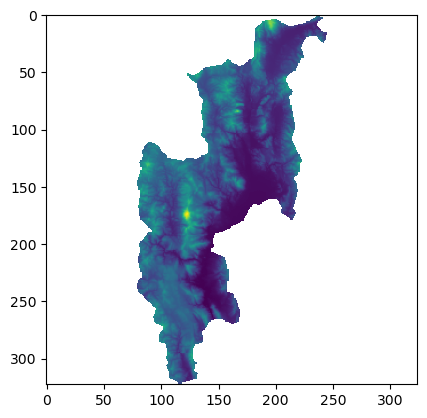

In [88]:
import matplotlib.pyplot as plt
plt.imshow(np.flip(z_data, axis=0))

In [93]:

import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=z_data)])

fig.update_layout(title='Chiangmai - Elevation Map', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=65, t=90))
map_range = np.max(z_data.shape)
fig.update_scenes(
    xaxis_range=[0, map_range],
    yaxis_range=[0, map_range],
    zaxis_range=[0, 30000])

fig.show()

23.815652097758708

In [56]:
dir_predicted_pm25_root = r'../../../data/predicted_pm25_chiangmai'
dir_predicted_pm25_daily = os.path.join(dir_predicted_pm25_root, 'daily')
dir_predicted_pm25_monthly = os.path.join(dir_predicted_pm25_root, 'monthly')
io_tools.create_folders(dir_predicted_pm25_raw, dir_predicted_pm25_daily, dir_predicted_pm25_monthly)


In [96]:
dir_chiangmai_aod_daily = r'../data/chiangmai_aod_daily'
list_file_aod_daily = io_tools.get_list_files(dir_chiangmai_aod_daily, '.parquet$')
pbar_aod_daily = tqdm(list_file_aod_daily)
for path_aod_daily in pbar_aod_daily:
    break

Total of 111 files have been listed.


  0%|          | 0/111 [00:00<?, ?it/s]

,dem
grid_id,
62620,756.0
62621,748.0
62622,813.0
62623,911.0
63065,879.0
...,...
205907,1424.0
205908,1234.0
205909,1286.0


In [102]:
df_aod_daily = pd.read_parquet(path_aod_daily)
df_aod_daily = df_chiangmai_dem.merge(df_aod_daily, how='inner', left_index=True, right_index=True)
pd.melt(df_aod_daily, )

,variable,value
0,dem,756.0
1,dem,748.0
2,dem,813.0
3,dem,911.0
4,dem,879.0
...,...,...
777541,2015-01-30,163.5
777542,2015-01-30,168.5
777543,2015-01-30,170.0
777544,2015-01-30,178.5
